# Gesture Recognition
The primary goal of this study is to design, develop, and validate a comprehensive deep learning framework that enables smart televisions to detect and interpret five distinct hand gestures in real time, thereby orchestrating a paradigm shift in how users interact with their televisions. To provide a fun feature for the smart-TV that is capable of recognising five various gestures that are done by the user, which will assist users in controlling the TV without the usage of a remote

In [1]:
!pip install scikit-image

Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip install imageio

Defaulting to user installation because normal site-packages is not writeable


In [15]:
import imageio.v2 as imageio

image = imageio.imread(r'C:\Users\kevin\Desktop\Project_data\train\WIN_20180907_15_35_09_Pro_Right Swipe_new\WIN_20180907_15_35_09_Pro_00016.png')


In [16]:
import numpy as np
import os
import datetime
import os
from skimage.transform import resize


The random seed set so that the results don't vary drastically.

In [17]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

The below code reads the contents of the 'train.csv' and 'val.csv' files, shuffles their lines using numpy's random permutation, and assigns them to train_doc and val_doc, respectively. The batch size for training is also set to 64.


In [18]:
train_doc = np.random.permutation(open('C:/Users/kevin/Desktop/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('C:/Users/kevin/Desktop/Project_data/val.csv').readlines())
batch_size = 64

## Generator
This is one of the most crucial sections of the code. The generator's overall architecture has been provided. As there are images of two different dimensions, the generator will preprocess the images and produce a batch of video frames. It is necessary experiment with certain aspects of the generator function to achieve high precision.

In [19]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29]
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(t)/batch_size)
        for batch in range(num_batches):
            batch_data = np.zeros((batch_size,18,84,84,3))
            batch_labels = np.zeros((batch_size,5))
            for folder in range(batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    if image.shape[1] == 160:
                        image = resize(image[:,20:140,:],(84,84)).astype(np.float32)
                    else:
                        image = resize(image,(84,84)).astype(np.float32)
                    
                    batch_data[folder,idx,:,:,0] = image[:,:,0] - 104
                    batch_data[folder,idx,:,:,1] = image[:,:,1] - 117
                    batch_data[folder,idx,:,:,2] = image[:,:,2] - 123
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,18,84,84,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    if image.shape[1] == 160:
                        image = resize(image[:,20:140,:],(84,84)).astype(np.float32)
                    else:
                        image = resize(image,(84,84)).astype(np.float32)

                    batch_data[folder,idx,:,:,0] = image[:,:,0] - 104
                    batch_data[folder,idx,:,:,1] = image[:,:,1] - 117
                    batch_data[folder,idx,:,:,2] = image[:,:,2] - 123

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

Next is to captures the current date and time, sets the paths for the training and validation datasets, calculates the number of training and validation sequences, and sets the number of epochs to 30, printing these values for reference.


In [20]:
curr_dt_time = datetime.datetime.now()
train_path = 'C:/Users/kevin/Desktop/Project_data/train'
val_path = 'C:/Users/kevin/Desktop/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 30
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 30


## Model CNN

The architecture of a 3D convolutional neural network built with Keras for processing 2D image sequences, such as video frames. Multiple 3D convolutional layers, each followed by batch normalisation and an ELU activation function, are interspersed with downsampling max-pooling layers in the network. The network then flattens the 3D data, incorporates dropout for regularisation, and concludes with two entirely connected layers. The model is designed to classify input data into one of five categories, as indicated by the final dense layer's five units with softmax activation.


In [1]:
from keras.models import Sequential
from keras.layers import Dense, GRU, Dropout, Flatten, BatchNormalization, Activation
from keras.layers import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

model = Sequential()
model.add(Conv3D(64, (3,3,3), strides=(1,1,1), padding='same', input_shape=(18,84,84,3)))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling3D(pool_size=(2,2,1), strides=(2,2,1)))

model.add(Conv3D(128, (3,3,3), strides=(1,1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

# model.add(Dropout(0.25))

model.add(Conv3D(256, (3,3,3), strides=(1,1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

# model.add(Dropout(0.25))

model.add(Conv3D(256, (3,3,3), strides=(1,1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='elu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

The next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [22]:
from tensorflow.keras.optimizers import legacy

sgd = legacy.SGD(learning_rate=0.001, decay=1e-6, momentum=0.7, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 18, 84, 84, 64)    5248      
                                                                 
 batch_normalization_4 (Bat  (None, 18, 84, 84, 64)    256       
 chNormalization)                                                
                                                                 
 activation_4 (Activation)   (None, 18, 84, 84, 64)    0         
                                                                 
 max_pooling3d_4 (MaxPoolin  (None, 9, 42, 84, 64)     0         
 g3D)                                                            
                                                                 
 conv3d_5 (Conv3D)           (None, 9, 42, 84, 128)    221312    
                                                                 
 batch_normalization_5 (Bat  (None, 9, 42, 84, 128)   

By configuring these generators, the code facilitates the efficient and dynamic loading of training and validation data during the training process of the model.

In [11]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [12]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', epsilon=0.0001, cooldown=0, min_lr=0.00001)
callbacks_list = [checkpoint, LR]

In [13]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Next step is to uses the Keras model to train a neural network model.fit method, utilising data from train_generator and val_generator, over a specified number of epochs, and with additional training configurations such as callbacks and validation steps.


In [15]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  C:/Users/kevin/Desktop/Project_data/train ; batch size = 64
Epoch 1/30
11/11 [==============================] - ETA: 0s - loss: 3.8953 - categorical_accuracy: 0.3047  Source path =  C:/Users/kevin/Desktop/Project_data/val ; batch size = 64

Epoch 1: saving model to model_init_2023-08-2414_18_01.344844\model-00001-3.89528-0.30468-13.58803-0.23000.h5
11/11 [==============================] - 1975s 181s/step - loss: 3.8953 - categorical_accuracy: 0.3047 - val_loss: 13.5880 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/30


C:\Users\kevin\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - ETA: 0s - loss: 1.8471 - categorical_accuracy: 0.4947  
Epoch 2: saving model to model_init_2023-08-2414_18_01.344844\model-00002-1.84707-0.49472-9.50758-0.18000.h5
11/11 [==============================] - 1900s 172s/step - loss: 1.8471 - categorical_accuracy: 0.4947 - val_loss: 9.5076 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 3/30
11/11 [==============================] - ETA: 0s - loss: 1.3716 - categorical_accuracy: 0.5928  
Epoch 3: saving model to model_init_2023-08-2414_18_01.344844\model-00003-1.37159-0.59276-6.61077-0.25000.h5
11/11 [==============================] - 2009s 180s/step - loss: 1.3716 - categorical_accuracy: 0.5928 - val_loss: 6.6108 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 4/30
11/11 [==============================] - ETA: 0s - loss: 1.0490 - categorical_accuracy: 0.6425  
Epoch 4: saving model to model_init_2023-08-2414_18_01.344844\model-00004-1.04900-0.64253-6.35795-0.24000.h5
11/11 [=============

NameError: name 'plot' is not defined

In [16]:
import matplotlib.pyplot as plt

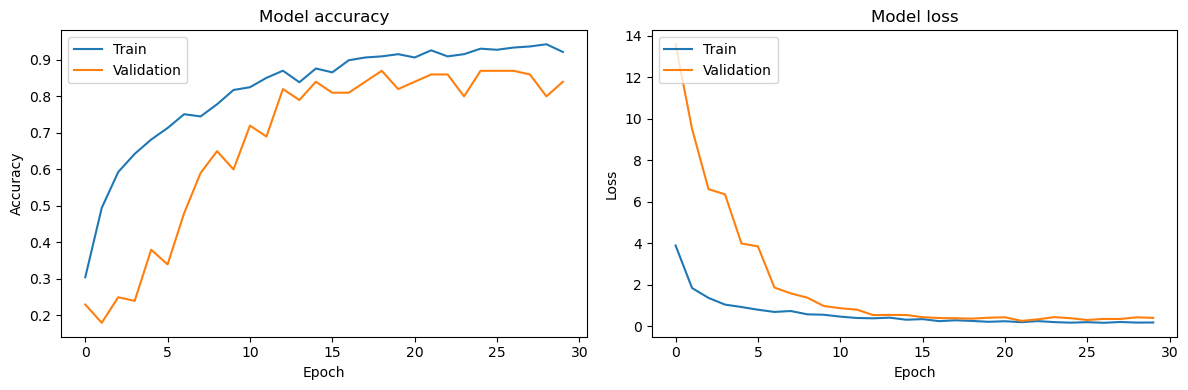

In [18]:
def plot(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.tight_layout()
    plt.show()

plot(history)


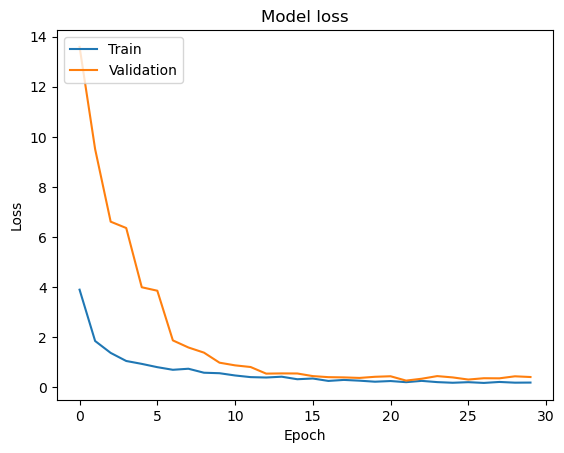

In [19]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [23]:
print(history.history.keys())

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


In [24]:
# Extract the training and validation loss from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# If you also tracked accuracy (or other metrics), you can extract them too:
train_accuracy = history.history['categorical_accuracy']
val_accuracy = history.history['val_categorical_accuracy']


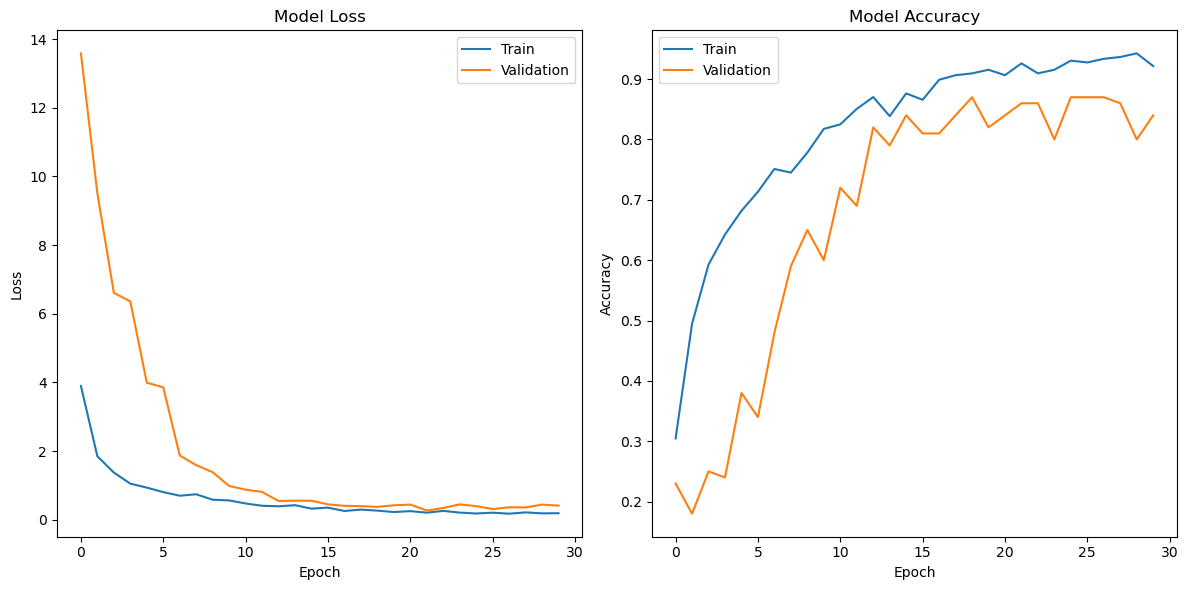

In [25]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(train_accuracy)
plt.plot(val_accuracy)
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


In [26]:
# Using your validation generator
val_loss, val_accuracy = model.evaluate(val_generator, steps=validation_steps)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')


2/2 [==============================] - 26s 19s/step - loss: 0.4115 - categorical_accuracy: 0.8300
Validation Loss: 0.4115495979785919
Validation Accuracy: 0.8299999833106995


In [46]:
# Save the model for later use
model.save('Gesture_CNN.h5')


C:\Users\kevin\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


PREDICTION

In [47]:
from keras.models import load_model

model = load_model(r'C:\Users\kevin\Desktop\gesture recog\models\Gesture_CNN.h5')


In [48]:
input_shape = model.layers[0].input_shape[1:3]
print("Image width:", input_shape[0])
print("Image height:", input_shape[1])


Image width: 15
Image height: 90


In [49]:
from keras.preprocessing import image

# Load the image
img_path = r'C:\Users\kevin\Desktop\Project_data\train\WIN_20180907_15_38_35_Pro_Thumbs Down_new\WIN_20180907_15_38_35_Pro_00044.png'
img = image.load_img(img_path, target_size=(90, 90))
img_tensor = image.img_to_array(img)

# Ensure img_tensor has shape (90, 90, 3)
assert img_tensor.shape == (90, 90, 3)

# Expand dimensions
img_tensor = np.expand_dims(img_tensor, axis=0)  # Shape: (1, 90, 90, 3)
img_tensor = np.expand_dims(img_tensor, axis=1)  # Shape: (1, 1, 90, 90, 3)

# Repeat for sequence length
img_sequence = np.repeat(img_tensor, 15, axis=1)  # Shape: (1, 15, 90, 90, 3)

# Predict
predictions = model.predict(img_sequence)


1/1 [==============================] - 1s 530ms/step


In [51]:
gesture_names = ['Swiping Left', 'Swiping Right', 'Stop', 'Thumps Down', 'Thumps Up']
predicted_gesture = gesture_names[np.argmax(predictions[0])]
print(f'The predicted gesture is: {predicted_gesture}')


The predicted gesture is: Swiping Left
